In [53]:
import numpy as np
import matplotlib.pyplot as plt
from deap import creator, base, tools, algorithms


In [54]:
class LinearRegression:

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        self.X_train = X / (np.amax(y))
        self.y_train = y / (np.amax(y))
        self.N_train = X.shape[0]
        self.M = X.shape[1]


    def to_int_tpl_map(self, line):
        return tuple(map(int, line.strip().split()))


    def fit_from_file(self, file_name=None, file=None):
        if file_name:
            file = open(file_name)
        raw_data = tuple(map(self.to_int_tpl_map, file.readlines()))
        self.M = int(raw_data[0][0])
        self.N_train = int(raw_data[1][0])
        train_data = np.array(raw_data[2:self.N_train+2])
        self.y_train = train_data[:, -1] / np.amax(train_data[:, -1])
        self.X_train = train_data[:,:-1] / np.amax(train_data[:, -1])
        self.N_test = int(raw_data[self.N_train+2][0])
        test_data = np.array(raw_data[self.N_train+3:])
        self.y_test = test_data[:,-1]
        self.X_test = test_data[:,:-1]


    def rmse_loss(self, y_pred):
        return np.sqrt((((y_pred - self.y_train)**2).sum())/self.N_train)

    def SVD(self, tay=1e-3):
        self.w = \
            self.X_train.T @ np.linalg.inv(self.X_train @ self.X_train.T + (1/2 * tay * np.eye(self.X_train.shape[0]))) @ self.y_train

    def gradient(self, tay=.1, lr=.01, batch_size=5, n_epochs=1000):

        def loss_derivative(y, y_pred):
            return -2 * (y - y_pred)
        self.w = np.random.sample(self.M)
        for it in range(n_epochs):
            if it % batch_size == 0:
                y_pred = self.X_train @ self.w
                loss_der = loss_derivative(self.y_train, y_pred)
                grad = (np.array([self.X_train[n]*loss_der[n] for n in range(self.N_train)])).sum(axis=0)/self.N_train\
                    + tay * self.w
                # print('grad:', ' '.join(map(str, grad)))
            self.w = self.w * (1 - lr * tay) - lr * grad


    def genetic(self, n_epochs=40):
        creator.create("FitnessMax", base.Fitness, weights=(-1.0,))
        creator.create("Individual", np.ndarray, fitness=creator.FitnessMax)

        toolbox = base.Toolbox()

        toolbox.register("attr_float", np.random.random)
        toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=self.M)
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)

        def eval_def(individual):
            return self.rmse_loss(self.X_train @ individual),

        toolbox.register("evaluate", eval_def)
        toolbox.register("mate", tools.cxTwoPoint)
        toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
        toolbox.register("select", tools.selTournament, tournsize=3)

        population = toolbox.population(n=300)

        for gen in range(n_epochs):
            offspring = algorithms.varAnd(population, toolbox, cxpb=0.5, mutpb=0.1)
            fits = toolbox.map(toolbox.evaluate, offspring)
            for fit, ind in zip(fits, offspring):
                ind.fitness.values = fit
            population = toolbox.select(offspring, k=len(population))
        self.w = tools.selBest(population, k=1)[0]


    def nrmse_score(self, X_test=None, y_test=None):
        if X_test:
            self.X_test = X_test
        if X_test:
            self.y_test = y_test
        y_pred = self.X_test @ self.w
        return np.sqrt(((y_pred - self.y_test)**2).sum()/self.y_test.shape[0])/(np.amax(self.y_test) - np.amin(self.y_test))


    def smape_score(self, X_test=None, y_test=None):
        if X_test and y_test:
            self.X_test = np.array(X_test)
            self.y_test = np.array(y_test)
            self.N_test = self.y_test.shape[0]
        y_pred = self.X_test  @ self.w
        return (100/self.N_test) * (np.absolute(self.y_test - y_pred)/(np.absolute(self.y_test) + np.absolute(y_pred))).sum()


In [55]:
reg = LinearRegression()
reg.fit_from_file("6.txt")

In [56]:
reg.SVD()
print('SVD tay: %2f    smape: %4f' % (1e-3, reg.smape_score()))
svd_x_plot = np.arange(0.01, 1.01, 0.01)
svd_y_plot = []
for tay in svd_x_plot:
    reg.SVD(tay)
    svd_y_plot.append(reg.smape_score())

SVD tay: 0.001000    smape: 0.038215


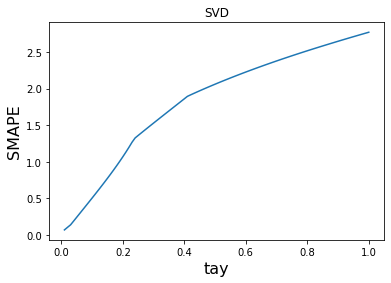

In [57]:
%matplotlib inline
plt.plot(svd_x_plot, svd_y_plot)
plt.title("SVD")
plt.ylabel('SMAPE', fontsize=16)
plt.xlabel('tay', fontsize=16)
# plt.xticks(np.arange(0, 1.01, 0.1))
plt.show()


In [58]:
grad_res = []
for n_epochs in [100, 500, 1000, 2000]:
    for batch_size in [100, 75, 50, 20, 10, 5 ,1]:
        for lr in 10.**np.arange(-4, -1):
            reg.gradient(lr=lr, batch_size=batch_size, n_epochs=n_epochs)
            smape = reg.smape_score()
            nrmse = reg.nrmse_score()
            grad_res.append([lr, batch_size, n_epochs, smape, nrmse])
            print('gradient: lr_%f, batch_size_%d, n_epochs_%d'%(lr, batch_size, n_epochs),smape)

sorted_res = sorted(grad_res, key=lambda x: x[4])[:10]
print('grad_top10: lr    batch size  n epochs    smape   nrmse\n', '\n'.join([' '.join(map(str, line)) for line in sorted_res]))

In [59]:
grad_top5 = sorted_res

In [60]:
print('grad_top5: lr    batch size  n epochs    smape   nrmse\n', '\n'.join([' '.join(map(str, line)) for line in grad_top5]))

In [61]:
grad_x_plot = list(range(0, 2001, 100))
grad_y_plot = []
for n_epochs in grad_x_plot:
    print(n_epochs, end='... ')
#     grad_top1 = grad_top5[0]
#     reg.gradient(lr=grad_top1[0], batch_size=grad_top1[1], n_epochs=n_epochs)
    reg.gradient(n_epochs=n_epochs)
    grad_y_plot.append(reg.smape_score())

0... 100... 200... 300... 400... 500... 600... 700... 800... 900... 1000... 1100... 1200... 1300... 1400... 1500... 1600... 1700... 1800... 1900... 2000... 

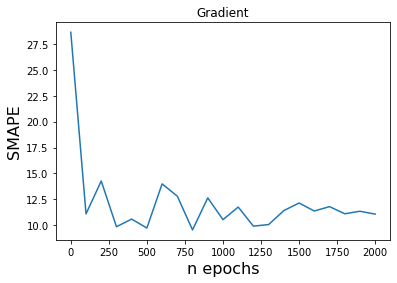

In [62]:
%matplotlib inline
plt.plot([ s for s in grad_x_plot], grad_y_plot)
plt.title("Gradient")
plt.ylabel('SMAPE', fontsize=16)
plt.xlabel('n epochs', fontsize=16)
plt.show()

In [63]:
grad_x_plot = np.arange(0.01, 1.01, 0.01)
grad_y_plot = []
for tay in grad_x_plot:
    reg.gradient(tay=tay)
    grad_y_plot.append(reg.smape_score())


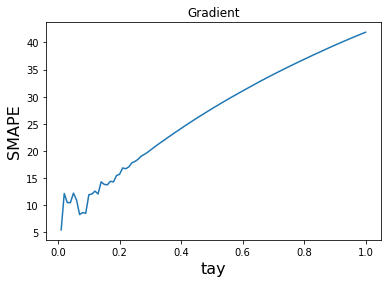

In [64]:
%matplotlib inline
plt.plot(grad_x_plot, grad_y_plot)
plt.title("Gradient")
plt.ylabel('SMAPE', fontsize=16)
plt.xlabel('tay', fontsize=16)
plt.show()

In [65]:
reg.genetic()
print(reg.nrmse_score())
print(reg.smape_score())

/home/neutralmike/Projects/ml_labs/venv/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/neutralmike/Projects/ml_labs/venv/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


0.0018962652701994024
0.835086966808288


In [66]:
genetic_x_plot = list(range(40))
genetic_y_plot = []
for n_epochs in genetic_x_plot:
    print(n_epochs, end='... ')
    reg.genetic(n_epochs=n_epochs)
    genetic_y_plot.append(reg.smape_score())
    print(' '.join(map(str, genetic_y_plot)))


0... 20.49990925692309
1... 20.49990925692309 6.640506228681085
2... 20.49990925692309 6.640506228681085 2.8577876083592737
3... 20.49990925692309 6.640506228681085 2.8577876083592737 4.233544068055369
4... 20.49990925692309 6.640506228681085 2.8577876083592737 4.233544068055369 2.0815599609211066
5... 20.49990925692309 6.640506228681085 2.8577876083592737 4.233544068055369 2.0815599609211066 2.2229090887052245
6... 20.49990925692309 6.640506228681085 2.8577876083592737 4.233544068055369 2.0815599609211066 2.2229090887052245 2.988356846867345
7... 20.49990925692309 6.640506228681085 2.8577876083592737 4.233544068055369 2.0815599609211066 2.2229090887052245 2.988356846867345 1.9461473031658059
8... 20.49990925692309 6.640506228681085 2.8577876083592737 4.233544068055369 2.0815599609211066 2.2229090887052245 2.988356846867345 1.9461473031658059 2.151651865579058
9... 20.49990925692309 6.640506228681085 2.8577876083592737 4.233544068055369 2.0815599609211066 2.2229090887052245 2.988356846

In [67]:
genetic_x_plot_copy = genetic_x_plot.copy()
genetic_y_plot_copy = genetic_y_plot.copy()

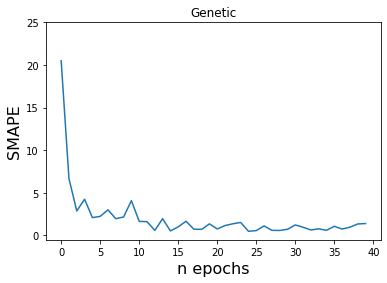

In [68]:
%matplotlib inline
plt.plot(genetic_x_plot, genetic_y_plot)
plt.title("Genetic")
plt.ylabel('SMAPE', fontsize=16)
plt.xlabel('n epochs', fontsize=16)
plt.xticks(list(range(0,41,5)))
plt.yticks(list(range(int(min(genetic_y_plot)//5)*5, int(max(genetic_y_plot)//5+2)*5, 5)))
plt.show()
